In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn.functional as F
from datasets import load_dataset
from PIL import Image
from sklearn.metrics import (
    ConfusionMatrixDisplay,
    confusion_matrix,
    f1_score,
    precision_score,
    recall_score,
)
from torch import nn
from torch.utils.data import DataLoader, Dataset, random_split
from torcheval.metrics import MulticlassAccuracy
from torchvision import datasets, transforms
from tqdm import tqdm

import wandb


## Data Loading


In [2]:
# set up the transform to resize the images
transform = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ]
)

batch_size = 64

# get labels from folder names
dataset = datasets.ImageFolder(root="data", transform=transform)

# create random train test split from data
rand_generator = torch.Generator().manual_seed(42)
train_dataaset, val_dataset, test_dataset = random_split(
    dataset, [0.8, 0.1, 0.1], generator=rand_generator
)
print(f"{len(train_dataaset)} training images")
print(f"{len(val_dataset)} validation images")
print(f"{len(test_dataset)} testing images")


train_dataloader = DataLoader(train_dataaset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)


4493 training images
562 validation images
561 testing images


In [3]:
# show the encoding for each class label
class_to_idx = dataset.class_to_idx
idx_to_class = {v: k for k, v in class_to_idx.items()}
print(idx_to_class)

{0: 'afghan', 1: 'chinese', 2: 'indian', 3: 'modern', 4: 'moroccan', 5: 'persian', 6: 'turkish'}


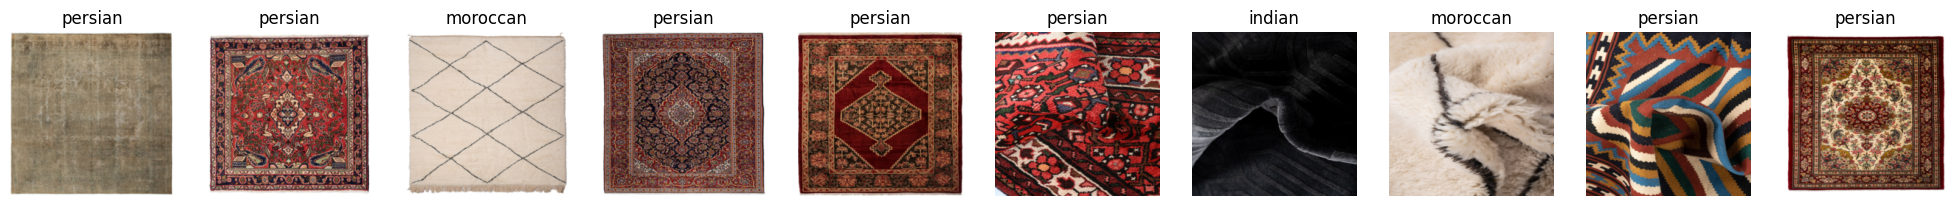

In [4]:
# convert tensor to numpy and plot as image
def imshow(image, ax=None, title=None) -> None:
    if ax is None:
        fig, ax = plt.subplots()
    # unnormalize the image
    image = image / 2 + 0.5
    image = image.numpy().transpose((1, 2, 0))
    ax.imshow(image)
    if title is not None:
        ax.set_title(title)
    ax.axis("off")


# plot training images
images, labels = next(iter(train_dataloader))
fig, axes = plt.subplots(1, 10, figsize=(25, 25))
for i in range(10):
    class_name = idx_to_class[int(labels[i])]
    imshow(images[i], ax=axes[i], title=class_name)
plt.show()


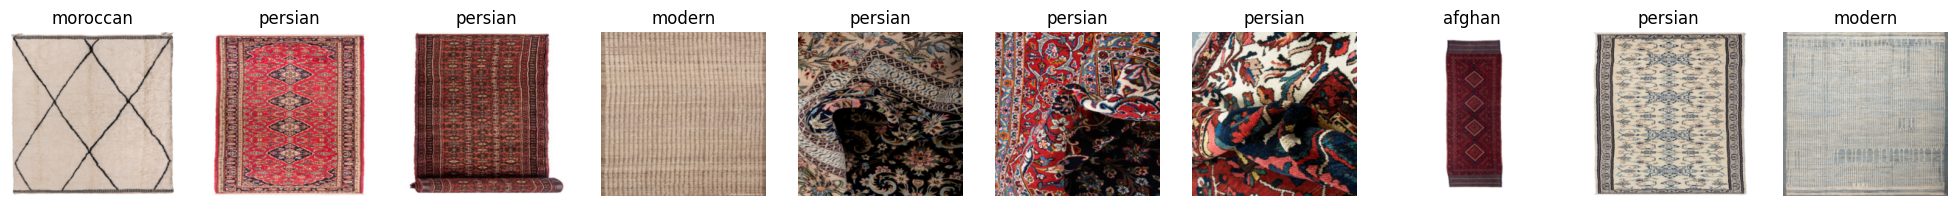

In [5]:
# plot validation images
images, labels = next(iter(val_dataloader))
fig, axes = plt.subplots(1, 10, figsize=(25, 25))
for i in range(10):
    class_name = idx_to_class[int(labels[i])]
    imshow(images[i], ax=axes[i], title=class_name)
plt.show()

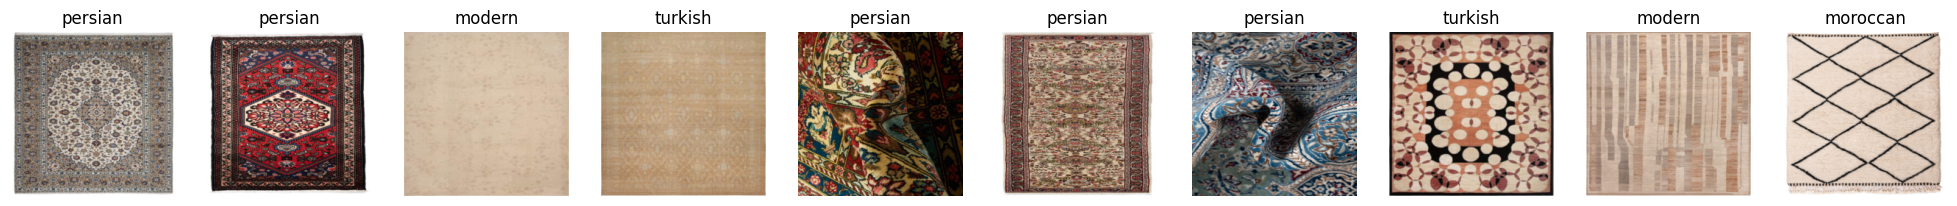

In [6]:
# plot test images
images, labels = next(iter(test_dataloader))
fig, axes = plt.subplots(1, 10, figsize=(25, 25))
for i in range(10):
    class_name = idx_to_class[int(labels[i])]
    imshow(images[i], ax=axes[i], title=class_name)
plt.show()

In [7]:
from collections import Counter

# Initialize a Counter to count instances
label_counts = Counter()

# Loop over the DataLoader to get the labels
for _, labels in train_dataloader:
    label_counts.update(labels.tolist())

# Convert the dataset class indices to class names
class_to_idx = dataset.class_to_idx
idx_to_class = {v: k for k, v in class_to_idx.items()}

# Print the counts for each class
print(f'Train dataset has:')
for label, count in label_counts.items():
    class_name = idx_to_class[label]
    print(f"Class {class_name} has {count} instances")


Train dataset has:
Class persian has 3257 instances
Class afghan has 190 instances
Class modern has 378 instances
Class indian has 103 instances
Class chinese has 79 instances
Class moroccan has 359 instances
Class turkish has 127 instances


In [8]:
# Initialize a Counter to count instances
label_counts = Counter()

# Loop over the DataLoader to get the labels
for _, labels in val_dataloader:
    label_counts.update(labels.tolist())

# Convert the dataset class indices to class names
class_to_idx = dataset.class_to_idx
idx_to_class = {v: k for k, v in class_to_idx.items()}

# Print the counts for each class
print(f'Validaiton dataset has:')
for label, count in label_counts.items():
    class_name = idx_to_class[label]
    print(f"Class {class_name} has {count} instances")

Validaiton dataset has:
Class afghan has 24 instances
Class modern has 54 instances
Class persian has 406 instances
Class chinese has 15 instances
Class moroccan has 40 instances
Class turkish has 11 instances
Class indian has 12 instances


In [9]:
from collections import Counter

# Initialize a Counter to count instances
label_counts = Counter()

# Loop over the DataLoader to get the labels
for _, labels in test_dataloader:
    label_counts.update(labels.tolist())

# Convert the dataset class indices to class names
class_to_idx = dataset.class_to_idx
idx_to_class = {v: k for k, v in class_to_idx.items()}

# Print the counts for each class
print(f'Test dataset has:')
for label, count in label_counts.items():
    class_name = idx_to_class[label]
    print(f"Class {class_name} has {count} instances")

Test dataset has:
Class persian has 423 instances
Class modern has 48 instances
Class afghan has 24 instances
Class moroccan has 35 instances
Class turkish has 15 instances
Class indian has 6 instances
Class chinese has 10 instances


## Model


In [10]:
class NeuralNetworkWithDropout(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.fc1 = nn.Linear(128 * 28 * 28, 512)
        self.dropout = nn.Dropout(p=0.5)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, len(dataset.class_to_idx))

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        return self.fc3(x)


model = NeuralNetworkWithDropout()

## Optimizer, loss and accuracy


In [11]:
# implement focal loss to address the class imbalance
class FocalLoss(nn.Module):
    """Implement focal loss to address the class imbalance in the data. Focal loss
    will adjust the loss by giving a higher weight to samples with lower probability
    of being correctly classified.

    https://arxiv.org/pdf/1708.02002
    """

    def __init__(self, alpha=1, gamma=2, reduction="mean"):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction
        self.name = "Focal Loss"

    def forward(self, inputs, targets):
        BCE_loss = F.cross_entropy(inputs, targets, reduction="none")
        # prevent NaNs when probability is 0 by computing probability of true class
        prob_true = torch.exp(-BCE_loss)
        F_loss = self.alpha * (1 - prob_true) ** self.gamma * BCE_loss

        if self.reduction == "none":
            pass
        elif self.reduction == "mean":
            return torch.mean(F_loss)
        elif self.reduction == "sum":
            return torch.sum(F_loss)
        else:
            msg = f"An invalid value was selected for arg 'reduction': {self.reduction} \n Supported reduction values: 'none', 'mean', 'sum'"
            raise ValueError(msg)


focal_loss = FocalLoss(alpha=0.25, gamma=2)

In [12]:
learning_rate = 0.02
# loss_fn = nn.CrossEntropyLoss()
loss_fn = focal_loss
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [13]:
def get_loss_fn_params(loss_fn):
    # Extract alpha, gamma, and reduction parameters from the loss function, if available
    params = {}
    for attr in ["alpha", "gamma", "reduction"]:
        if hasattr(loss_fn, attr):
            params[attr] = getattr(loss_fn, attr)
    return params


def initialize_wandb(model, train_dataloader, learning_rate, epochs, loss_fn, patience):
    config = {
        "learning_rate": learning_rate,
        "architecture": model.__class__.__name__,
        "dataset": "rugs",
        "epochs": epochs,
        "batch_size": train_dataloader.batch_size,
        "loss_function": loss_fn.__class__.__name__,
        "patience": patience,
    }

    for name, module in model.named_modules():
        if isinstance(module, (nn.Conv2d, nn.Linear)):
            config[name] = {
                "in_channels"
                if isinstance(module, nn.Conv2d)
                else "in_features": module.in_channels
                if isinstance(module, nn.Conv2d)
                else module.in_features,
                "out_channels"
                if isinstance(module, nn.Conv2d)
                else "out_features": module.out_channels
                if isinstance(module, nn.Conv2d)
                else module.out_features,
            }
        if isinstance(module, nn.Dropout):
            config[f"{name}_dropout_rate"] = module.p

    loss_fn_params = get_loss_fn_params(loss_fn)
    config.update(loss_fn_params)

    wandb.init(
        project="rugai",
        config=config,
    )

## Training


In [14]:
def train_model(
    model,
    train_loader,
    val_loader,
    criterion,
    optimizer,
    num_epochs,
    device,
    num_classes,
    model_name,
    save_every=2,
    early_stopping_patience=None,
):
    """
    Training loop with wandb integration and MulticlassAccuracy metric

    Args:
        model: PyTorch model
        train_loader: Training data loader
        val_loader: Validation data loader
        criterion: Loss function
        optimizer: Optimizer
        num_epochs: Maximum number of epochs
        device: Device to train on ('cuda' or 'cpu')
        project_name: WandB project name
        model_name: Name for saving model checkpoints
        num_classes: Number of classes for accuracy metric
        save_every: Save model every N epochs
        early_stopping_patience: Number of epochs to wait before early stopping
    """

    # Initialize wandb
    initialize_wandb(
        model,
        train_loader,
        learning_rate,
        num_epochs,
        criterion,
        early_stopping_patience,
    )

    print(f"Using {device} device")

    # Log model architecture
    wandb.watch(model)

    # Initialize accuracy metrics
    train_accuracy = MulticlassAccuracy(num_classes=num_classes).to(device)
    val_accuracy = MulticlassAccuracy(num_classes=num_classes).to(device)

    # Move model to device
    model = model.to(device)

    best_val_loss = float("inf")
    patience_counter = 0

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_loss = 0

        train_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Train]")
        for batch_idx, (data, target) in enumerate(train_bar):
            data, target = data.to(device), target.to(device)

            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)

            loss.backward()
            optimizer.step()

            # Update metrics
            train_loss += loss.item()
            # Update accuracy metric (accumulates automatically)
            train_accuracy.update(output, target)

            # Get current accuracy for progress bar
            current_train_acc = train_accuracy.compute()

            # Update progress bar
            train_bar.set_postfix(
                {
                    "loss": f"{train_loss/(batch_idx+1):.4f}",
                    "acc": f"{100.*current_train_acc:.2f}%",
                }
            )

        # Get final training accuracy for the epoch
        final_train_acc = train_accuracy.compute()
        # Reset training accuracy for next epoch
        train_accuracy.reset()

        # Validation phase
        model.eval()
        val_loss = 0

        with torch.no_grad():
            val_bar = tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Val]")
            for batch_idx, (data, target) in enumerate(val_bar):
                data, target = data.to(device), target.to(device)

                output = model(data)
                loss = criterion(output, target)

                # Update metrics
                val_loss += loss.item()
                # Update accuracy metric (accumulates automatically)
                val_accuracy.update(output, target)

                # Get current accuracy for progress bar
                current_val_acc = val_accuracy.compute()

                # Update progress bar
                val_bar.set_postfix(
                    {
                        "loss": f"{val_loss/(batch_idx+1):.4f}",
                        "acc": f"{100.*current_val_acc:.2f}%",
                    }
                )

        # Get final validation accuracy for the epoch
        final_val_acc = val_accuracy.compute()
        # Reset validation accuracy for next epoch
        val_accuracy.reset()

        # Calculate epoch metrics
        epoch_train_loss = train_loss / len(train_loader)
        epoch_val_loss = val_loss / len(val_loader)

        # Log metrics to wandb
        wandb.log(
            {
                "epoch": epoch + 1,
                "train_loss": epoch_train_loss,
                "train_acc": final_train_acc * 100,
                "val_loss": epoch_val_loss,
                "val_acc": final_val_acc * 100,
            }
        )

        # Save model checkpoint
        if (epoch + 1) % save_every == 0:
            checkpoint_path = f"{model_name}_epoch_{epoch+1}.pt"
            torch.save(
                {
                    "epoch": epoch,
                    "model_state_dict": model.state_dict(),
                    "optimizer_state_dict": optimizer.state_dict(),
                    "train_loss": epoch_train_loss,
                    "val_loss": epoch_val_loss,
                },
                checkpoint_path,
            )

            # Log model checkpoint to wandb
            wandb.save(checkpoint_path)

        # Early stopping
        if early_stopping_patience:
            if epoch_val_loss < best_val_loss:
                best_val_loss = epoch_val_loss
                patience_counter = 0
                # Save best model
                torch.save(model.state_dict(), f"{model_name}_best.pt")
                wandb.save(f"{model_name}_best.pt")
            else:
                patience_counter += 1
                if patience_counter >= early_stopping_patience:
                    print(f"Early stopping triggered after {epoch + 1} epochs")
                    break

    wandb.finish()
    return model


# Initialize wandb
wandb.login()

# Train the model
trained_model = train_model(
    model=model,
    train_loader=train_dataloader,
    val_loader=val_dataloader,
    criterion=loss_fn,
    optimizer=optimizer,
    num_epochs=300,
    device=torch.device(
        "cuda"
        if torch.cuda.is_available()
        else "mps"
        if torch.backends.mps.is_available()
        else "cpu"
    ),
    num_classes=len(class_to_idx),
    model_name=model.__class__.__name__,
    save_every=2,
    early_stopping_patience=10,
)

wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: jakeson99 (jakeson99-n-a). Use `wandb login --relogin` to force relogin


Using mps device


Epoch 32/300 [Val]: 100%|██████████| 9/9 [00:12<00:00,  1.35s/it, loss=0.0438, acc=90.04%]


Early stopping triggered after 32 epochs


epoch,▁▁▁▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▇▇▇▇███
train_acc,▁▃▄▄▄▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇▇█████████
train_loss,█▆▅▅▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁
val_acc,▅▅▆▁▆▇▆▆▇▇▇▇▇▇▇▇█▇▆▆█████▃▇█▇█▇█
val_loss,▇▆▅█▃▃▃▃▂▃▂▂▂▂▂▁▁▃▅▃▂▁▁▁▂▇▃▁▂▂▁▁
epoch,32
train_acc,97.77431
train_loss,0.00783
val_acc,90.03559
val_loss,0.04381


## Testing


In [20]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)

In [21]:
# Assuming class_to_idx is already defined
class_to_idx = dataset.class_to_idx
idx_to_class = {v: k for k, v in class_to_idx.items()}

# Set the model to evaluation mode
model.eval()

# Retrieve a single image and label from the test dataloader
images, labels = next(iter(test_dataloader))
images, labels = images.to(device), labels.to(device)

# Make a prediction
with torch.no_grad():
    outputs = model(images)
    _, preds = torch.max(outputs, 1)

# Print the predicted label for the first image
image = images[0]
predicted_label = preds[0].item()
true_label = labels[0].item()

print(f"Predicted: {idx_to_class[predicted_label]}, True: {idx_to_class[true_label]}")

Predicted: moroccan, True: moroccan


## Predict on single image


In [22]:
# Assuming class_to_idx and your model are already defined
class_to_idx = dataset.class_to_idx
idx_to_class = {v: k for k, v in class_to_idx.items()}


# Load an arbitrary image
def load_image(image_path):
    transform = transforms.Compose(
        [
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ]
    )
    image = Image.open(image_path)
    image = transform(image).unsqueeze(0)  # Add a batch dimension
    return image


# Predict the class for the given image
def predict_image_class(image_path, model):
    image = load_image(image_path).to(device)
    model.eval()
    with torch.no_grad():
        output = model(image)
        _, predicted = torch.max(output, 1)
        predicted_class = predicted.item()
        class_name = idx_to_class[predicted_class]
        return class_name


# Example usage
image_path = "predict/IMG_2341.jpg"
predicted_class_name = predict_image_class(image_path, model)
print(f"The predicted class for the image is: {predicted_class_name}")

The predicted class for the image is: persian


### Evaluation of Test Data


In [28]:
def evaluate_model(all_preds, all_labels, num_classes, device="mps"):
    """
    Evaluate model predictions using MulticlassAccuracy

    Args:
        all_preds: Predictions array/tensor (numpy array or torch tensor)
        all_labels: Ground truth labels array/tensor (numpy array or torch tensor)
        num_classes: Number of classes in the dataset
        device: Device to compute accuracy on ('cuda' or 'cpu')

    Returns:
        float: Accuracy score
    """
    # Convert numpy arrays to torch tensors if necessary
    if isinstance(all_preds, np.ndarray):
        all_preds = torch.from_numpy(all_preds)
    if isinstance(all_labels, np.ndarray):
        all_labels = torch.from_numpy(all_labels)

    # Ensure tensors are of type Long/int64
    all_preds = all_preds.long()
    all_labels = all_labels.long()

    # Move tensors to specified device
    all_preds = all_preds.to(device)
    all_labels = all_labels.to(device)

    # Initialize and compute accuracy
    accuracy = MulticlassAccuracy(num_classes=num_classes).to(device)
    accuracy.update(all_preds, all_labels)
    return accuracy.compute().item()

Precision: 0.8196
Recall: 0.6850
F1 Score: 0.7275
Accuracy: 0.9198
Class afghan - FPR: 0.0019, Recall: 0.5417
Class chinese - FPR: 0.0018, Recall: 0.6000
Class indian - FPR: 0.0018, Recall: 0.1667
Class modern - FPR: 0.0253, Recall: 0.8958
Class moroccan - FPR: 0.0133, Recall: 0.8857
Class persian - FPR: 0.1522, Recall: 0.9716
Class turkish - FPR: 0.0018, Recall: 0.7333


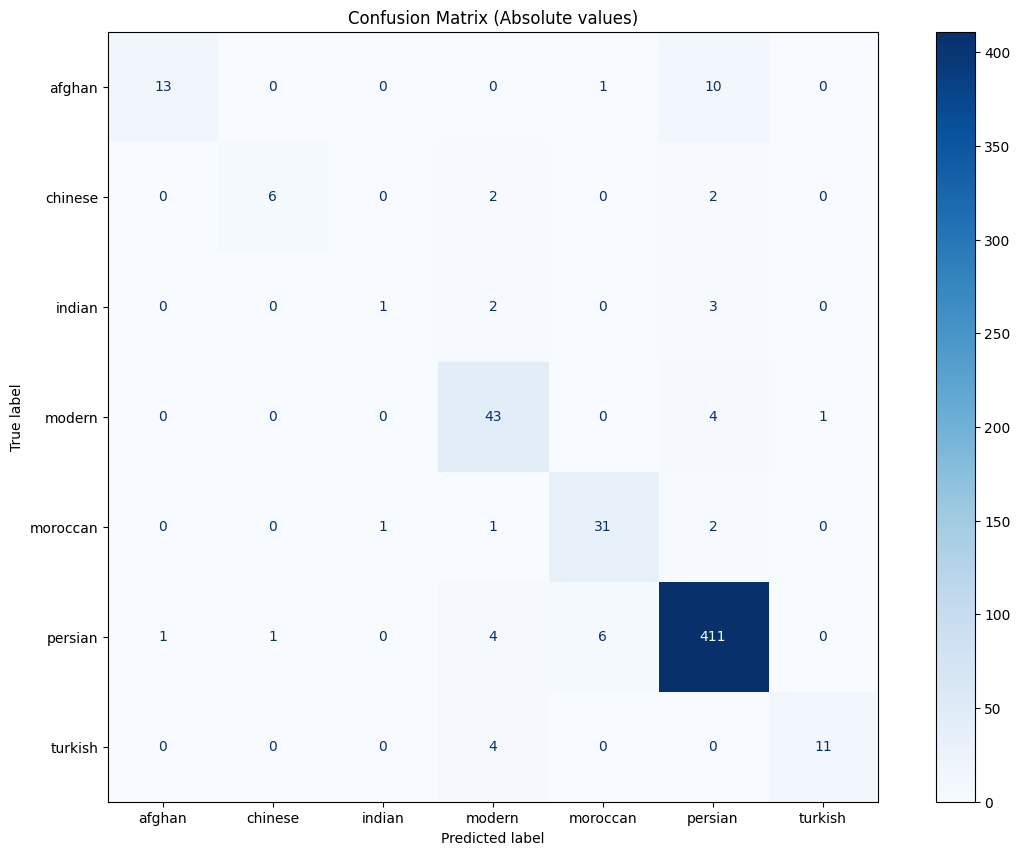

In [29]:
def get_predictions(model, dataloader, device):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            all_preds.append(preds.cpu().numpy())
            all_labels.append(labels.cpu().numpy())
    all_preds = np.concatenate(all_preds)
    all_labels = np.concatenate(all_labels)
    return all_preds, all_labels


# Generate predictions
all_preds, all_labels = get_predictions(model, test_dataloader, device)

# Calculate precision, recall, and f1 scores
precision = precision_score(all_labels, all_preds, average="macro")
recall = recall_score(all_labels, all_preds, average="macro")
f1 = f1_score(all_labels, all_preds, average="macro")
accuracy = evaluate_model(all_preds, all_labels, len(idx_to_class), device)

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"Accuracy: {accuracy:.4f}")

# create confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# Calculate False Positive Rate for each class
FP = cm.sum(axis=0) - np.diag(cm)
FN = cm.sum(axis=1) - np.diag(cm)
TP = np.diag(cm)
TN = cm.sum() - (FP + FN + TP)

# False Positive Rate: FP / (FP + TN)
FPR = FP / (FP + TN)

# Recall: TP / (TP + FN)
Recall = TP / (TP + FN)

for i, fpr in enumerate(FPR):
    class_name = list(class_to_idx.keys())[i]
    print(f"Class {class_name} - FPR: {FPR[i]:.4f}, Recall: {Recall[i]:.4f}")

disp = ConfusionMatrixDisplay(
    confusion_matrix=cm, display_labels=list(class_to_idx.keys())
)
fig, ax = plt.subplots(figsize=(15, 10))
disp.plot(cmap=plt.cm.Blues, ax=ax)
plt.title("Confusion Matrix (Absolute values)")
plt.show()


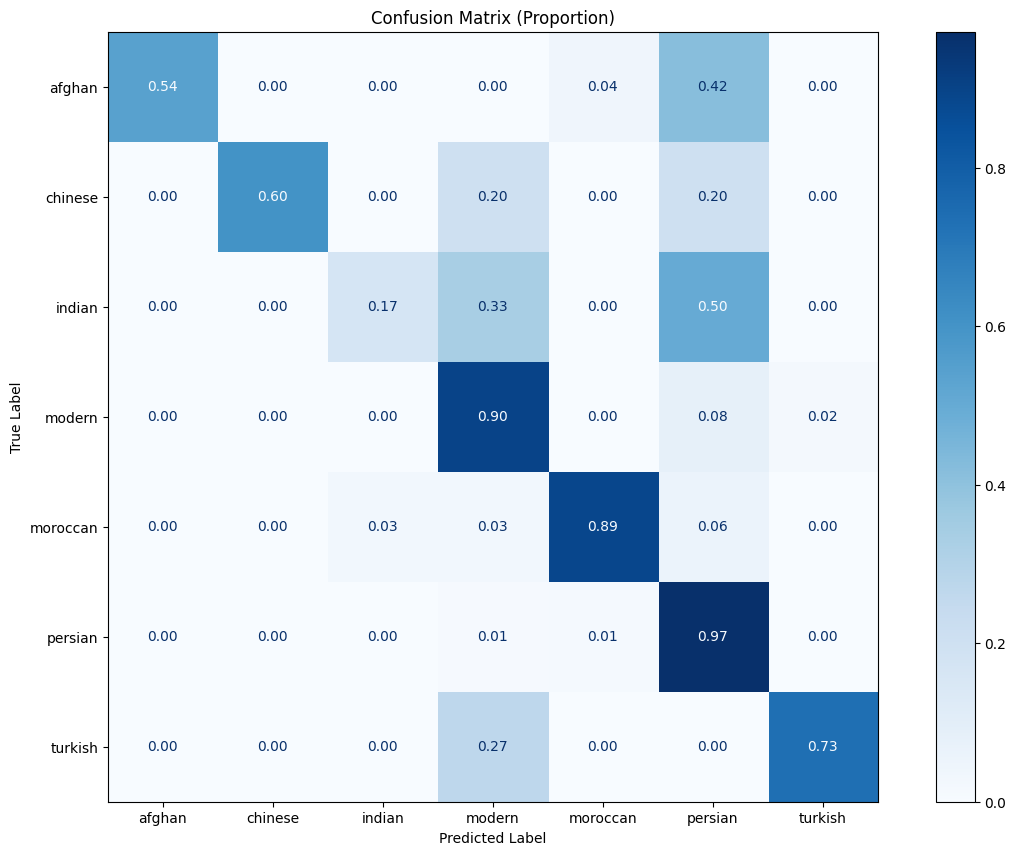

In [24]:
cm_normalized = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]

fig, ax = plt.subplots(figsize=(15, 10))
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm_normalized, display_labels=list(class_to_idx.keys())
)
disp.plot(cmap=plt.cm.Blues, ax=ax, values_format=".2f")
plt.title("Confusion Matrix (Proportion)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")

plt.show()
